In [ ]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [ ]:
!pip install -q contractions==0.0.48

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 5.4 MB/s eta 0:00:00


In [ ]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [ ]:
# Using TPU

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d sunnysai12345/news-summary
! unzip news-summary.zip -d train

 81% 16.0M/19.8M [00:00<00:00, 162MB/s]
100% 19.8M/19.8M [00:00<00:00, 174MB/s]
Archive:  news-summary.zip
  inflating: train/news_summary.csv  
  inflating: train/news_summary_more.csv  


In [ ]:
filename1 = 'train/news_summary.csv'
filename2 = 'train/news_summary_more.csv'

df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)
df2 = pd.read_csv(filename2, encoding='iso-8859-1').reset_index(drop=True)

In [ ]:
df1.sample(5)

,author,date,headlines,read_more,text,ctext
3228,Mansha Mahajan,"25 May 2017,Thursday",Indian economy has ?5 lakh crore less cash aft...,http://indiatoday.intoday.in/story/narendra-mo...,According to an internal report on the benefit...,Thanks to demonetisation the Indian economy is...
3803,Daisy Mowke,"14 Apr 2017,Friday",Women share pictures of 'feather eyebrows' on ...,http://indiatoday.intoday.in/story/feather-eye...,Several women are taking to Instagram to post ...,Let's not even get started on how strange cert...
483,Mansha Mahajan,"26 Jul 2017,Wednesday",Railways cancels caterer's contract as lizard ...,http://indiatoday.intoday.in/story/lizard-in-r...,The Ministry of Railways has cancelled a cater...,"New Delhi, Jul 26 (PTI) The railway ministry t..."
65,Daisy Mowke,"02 Aug 2017,Wednesday",Kriti replies to Hate Story actress Bhairavi's...,http://www.hindustantimes.com/bollywood/bhaira...,"Kriti Sanon, when asked about 'Hate Story' act...",It was last week that Kriti Sanon posted a vid...
4114,Daisy Mowke,"24 Mar 2017,Friday",Mom gets call from school after kid takes vodk...,http://indiatoday.intoday.in/story/mother-call...,"A woman from Queensland, Australia received a ...","A woman hailing from Queensland, Australia, mu..."


In [ ]:
df1_columns = df1.columns.tolist()
df1_columns.remove('headlines')
df1_columns.remove('text')
df1.drop(df1_columns, axis='columns', inplace=True)

df = pd.concat([df1, df2], axis='rows')
del df1, df2

# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102915


,headlines,text
90392,Emirates business class crew pours champagne b...,An Emirates air hostess can be seen pouring ch...
81567,Will pass word 'intercourse' in SRK film on 1L...,CBFC chief Pahlaj Nihalani has said he'll clea...
21031,Passenger records fatal plane crash in South A...,A footage of a plane crash purportedly shot by...
66480,4 dead trying to save man who fell off train t...,Four youths from West Bengal were killed while...
77347,US citizen fighting for ISIS surrenders in Syria,A US citizen fighting for ISIS in Syria has su...


In [ ]:
df['text'][0]

"The World Health Organisation (WHO) has warned there aren't enough antibiotics being developed to tackle the crisis of drug-resistant infections that kill seven lakh people per year globally. The report further highlights multidrug-resistant tuberculosis for which just 52% of the patients are successfully treated, while only two new antibiotics have reached the market in 70 years."

In [ ]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [ ]:
# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)

df.sample(5)

,headlines,text
55703,google to not renew military drone ai project ...,google has said it will not renew its artifici...
40870,govt sanctions ã¢ââ¹1000 crore for research i...,"the government has sanctioned ã¢ââ¹1,000 cror..."
33335,google may buy nokia's broadband tech for in-f...,technology giant google is in advanced talks t...
69931,jadhav's meeting with family a cruel joke: sar...,"sarabjit singh's sister, dalbir kaur, has said..."
44939,kung fu master uses his penis to tow bus,a video from china shows a kung fu master usin...


In [ ]:
df['text'][0]

"the world health organisation (who) has warned there aren't enough antibiotics being developed to tackle the crisis of drug-resistant infections that kill seven lakh people per year globally. the report further highlights multidrug-resistant tuberculosis for which just 52% of the patients are successfully treated, while only two new antibiotics have reached the market in 70 years."

In [ ]:
test = df['text'][0]

In [ ]:
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)

,headlines,text
47211,doors of hinduism open as all of us originally...,rss chief mohan bhagwat on monday said the doo...
66505,lactalis recalls baby milk as 26 children fall...,french baby milk maker lactalis and health aut...
79590,"us senate clears new sanctions against russia,...",the us senate on thursday voted 98-2 to impose...
94412,rishi kapoor bought his filmfare award for ?30...,actor rishi kapoor bought his filmfare award f...
83912,russia denies mh17 brought down by its militar...,russia on thursday rejected an international i...


In [ ]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [ ]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [ ]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [ ]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

,headlines,text
74614,saudi arabia resumes oil exports red sea lane,saudi arabia saturday resumed exports oil red ...
27540,garbage bins reintroduced bengaluru yrs,karnataka government reintroduced garbage bins...
21302,ib ministry increases ad rates private tv chan...,information broadcasting ib ministry friday in...
90389,bitcoin price soars reach alltime high,price worlds largest cryptocurrency bitcoin th...
65754,kissing baba held sexually exploiting fthemale...,selfstyled godman known kissing baba arrested ...


In [ ]:
df['text'][0]

'world health organisation warned enough antibiotics developed tackle crisis drugresistant infections kill seven lakh people per year globally report highlights multidrugresistant tuberculosis patients successfully treated two new antibiotics reached et years'

In [ ]:
test1=clean_text(test)
print(test)
print(test1)

the world health organisation (who) has warned there aren't enough antibiotics being developed to tackle the crisis of drug-resistant infections that kill seven lakh people per year globally. the report further highlights multidrug-resistant tuberculosis for which just 52% of the patients are successfully treated, while only two new antibiotics have reached the market in 70 years.
world health organisation warned arent enough antibiotics developed tackle crisis drugresistant infections kill seven lakh people per year globally report highlights multidrugresistant tuberculosis patients successfully treated two new antibiotics reached market years


In [ ]:
# saving the cleaned data
df.to_csv('cleaned_data.csv')

In [ ]:
df.head()

,headlines,text
0,enough antibiotics tackle drugresistance crisis,world health organisation warned enough antibi...
1,ec sets new dates bengal panchayat polls post ...,west bengal election commission announced panc...
2,putin critic denis voronenkov shot dead ukraine,former russian mp denis voronenkov critic russ...
3,sasikala allowed jail visits instead rti,rti reply revealed aiadmk leader sasikala allo...
4,k women died due dowry harassment ncrb,national crime records bureau ncrb stated many...


In [ ]:
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')


In [ ]:
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

In [ ]:
df.sample(5)


,headlines,text
77962,sostok _START_ sushant praises exgirlfriend an...,praising exgirlfriend ankita lokhandes look up...
37302,sostok _START_ shashi tharoor derek ofbrien ta...,congress mp shashi tharoor tmc mp derek ofbrie...
74770,sostok _START_ man arrested shoving railway th...,man arrested shoving yearold cleaner onto trai...
36312,sostok _START_ snake longest python species la...,reticulated python longest snake species world...
59627,sostok _START_ disagree mock others dignity pr...,addressing nation eve republic day president r...


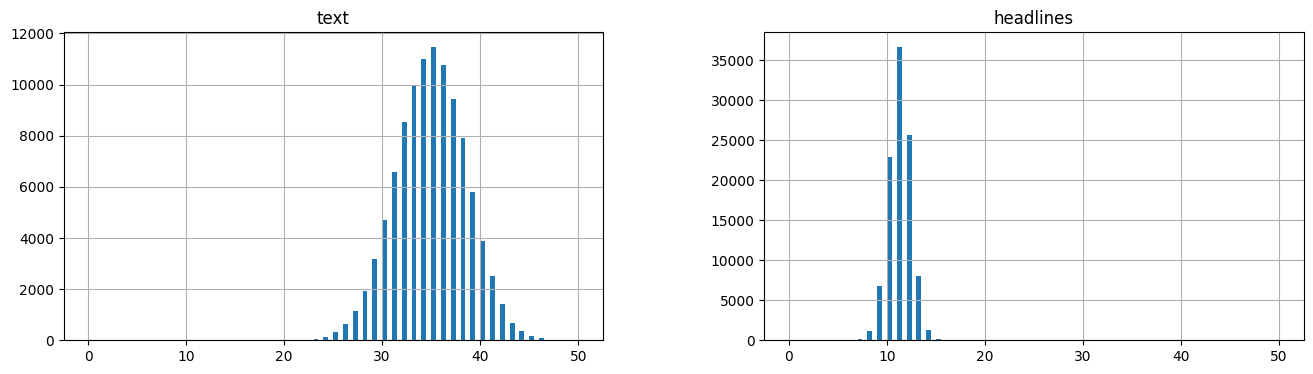

In [ ]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [ ]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 42))

0.99
0.99


In [ ]:
max_text_len = 42
max_summary_len = 13

In [ ]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 100258


,text,summary
36064,us president donald trump announced support le...,sostok _START_ trumps new immigration policy f...
90906,people rent luxury hotel rooms minute new york...,sostok _START_ people rent hotel rooms minute ...
89394,official twitter account county championship s...,sostok _START_ county calls keeper crickets de...
29591,pakistani actress mahira khan said completely ...,sostok _START_ shattered broken mahira pic ran...
40779,replying shah rukh khans tweet film baazigar c...,sostok _START_ kaali kaali aankhen ipl srk roh...


In [ ]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [ ]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

In [ ]:
df['text'][0]

'world health organisation warned enough antibiotics developed tackle crisis drugresistant infections kill seven lakh people per year globally report highlights multidrugresistant tuberculosis patients successfully treated two new antibiotics reached et years'

In [ ]:
given=x_val[0:1]

In [ ]:
print(x_val[0])
given[0]="cricket match hinckley amateur thirds hathern old seconds swallows green hinckley leicestershire halted macaw landed shoulders sexagenarian fielder hathern old seconds innings stop game bird big enough take someone finger batting sides captain said"
print(type(given))

least tourists including foreigners usa singapore oman saudi arabia russia uae trapped resort thursday landslide near munnar kerala following heavy showers third time landslide occurred near resort closed twice earlier located environmentallyfragile area
<class 'numpy.ndarray'>


In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 65.39, 'total_coverage': 2.96, 'count': 65317, 'total_count': 99887}


In [ ]:
test_tokenizer = Tokenizer()
test_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)

In [ ]:
test1_tokenizer=Tokenizer()
test1_tokenizer.fit_on_texts(test1)

In [ ]:
# x_tokenizer = Tokenizer(num_words=x_tokens_data['total_count'] - x_tokens_data['count'])

In [ ]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

99888


In [ ]:
given_sequence=x_tokenizer.texts_to_sequences(given)
given_padded=pad_sequences(given_sequence, maxlen=max_text_len, padding='post')

In [ ]:
print(type(x_val_padded))
print(type(given_padded))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(x_train_sequence[0])

[14, 466, 5768, 303, 1377, 3636, 3608, 10079, 36, 16485, 2086, 4733, 491, 6218, 8118, 20, 1275, 22018, 54998, 70, 3609, 466, 225, 20, 3608, 900, 18666, 135, 36, 809, 2127, 2372, 18667]


In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 69.13, 'total_coverage': 4.79, 'count': 25865, 'total_count': 37413}


In [ ]:
# y_tokenizer = Tokenizer(num_words=y_tokens_data['total_count'] - y_tokens_data['count'])

In [ ]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

37414


In [ ]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

In [ ]:
given_padded = np.delete(given_padded, remove_val_indexes, axis=0)
print((x_val_padded[0]))
print((given_padded[0]))

[  110   109 40701 10982 86134 52875   580  1239 86135  1438 40701 27179
  4597 34408  1984  8275 86136 10613 52875   580  1239   599   476   520
  3853   569  1088    99   800  4695  1951  2208   102     1     0     0
     0     0     0     0     0     0]
[  110   109 40701 10982 86134 52875   580  1239 86135  1438 40701 27179
  4597 34408  1984  8275 86136 10613 52875   580  1239   599   476   520
  3853   569  1088    99   800  4695  1951  2208   102     1     0     0
     0     0     0     0     0     0]


In [ ]:
x_val_padded[0]
# test1_padded[0]

array([  110,   109, 40701, 10982, 86134, 52875,   580,  1239, 86135,
        1438, 40701, 27179,  4597, 34408,  1984,  8275, 86136, 10613,
       52875,   580,  1239,   599,   476,   520,  3853,   569,  1088,
          99,   800,  4695,  1951,  2208,   102,     1,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [ ]:
latent_dim = 240
embedding_dim = 300
num_epochs = 50

In [ ]:
! kaggle datasets download -d nirbhayadhikari/glove6b
! unzip glove6b.zip -d train

 97% 439M/454M [00:06<00:00, 102MB/s]
100% 454M/454M [00:06<00:00, 77.0MB/s]
Archive:  glove6b.zip
  inflating: train/glove.6B.300d.txt/glove.6B.300d.txt  
  inflating: train/glove.6B.50d.txt/glove.6B.50d.txt  


In [ ]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = 'train/glove.6B.300d.txt/glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 55300 words (44587 misses)
Found 400000 word vectors.
Converted 27055 words (10358 misses)


In [ ]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(99888, 300)
(37414, 300)


In [ ]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():


        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        # =====================
        #  Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [ ]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 42, 300)      29966400    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 42, 240),    519360      ['embedding[0][0]']              
                                 (None, 240),                                                 

In [ ]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [ ]:
model.layers[-2].input


[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    # batch_size=128 * tpu_strategy.num_replicas_in_sync,

    batch_size=128,
callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
705/705 [==============================] - 85s 86ms/step - loss: 5.4595 - accuracy: 0.3868 - val_loss: 5.0244 - val_accuracy: 0.4338 - lr: 0.0010
Epoch 2/50
705/705 [==============================] - 37s 52ms/step - loss: 5.1332 - accuracy: 0.4212 - val_loss: 4.9185 - val_accuracy: 0.4361 - lr: 0.0010
Epoch 3/50
705/705 [==============================] - 37s 53ms/step - loss: 4.9536 - accuracy: 0.4259 - val_loss: 4.6975 - val_accuracy: 0.4396 - lr: 0.0010
Epoch 4/50
705/705 [==============================] - 38s 54ms/step - loss: 4.6993 - accuracy: 0.4329 - val_loss: 4.4475 - val_accuracy: 0.4481 - lr: 0.0010
Epoch 5/50
705/705 [==============================] - 37s 53ms/step - loss: 4.5096 - accuracy: 0.4389 - val_loss: 4.2894 - val_accuracy: 0.4544 - lr: 0.0010
Epoch 6/50
705/705 [==============================] - 37s 52ms/step - loss: 4.3477 - accuracy: 0.4448 - val_loss: 4.1645 - val_accuracy: 0.4586 - lr: 0.0010
Epoch 7/50
705/705 [==============================] - 37s 

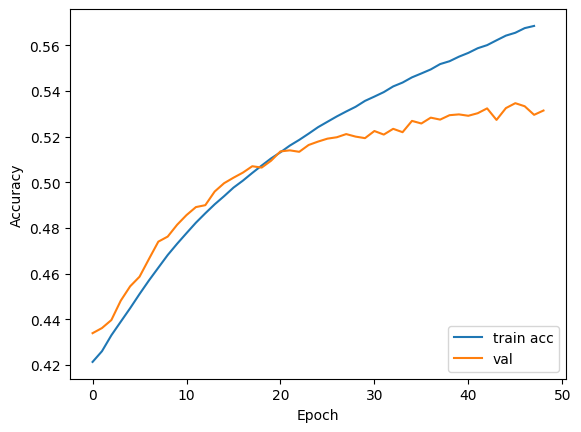

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

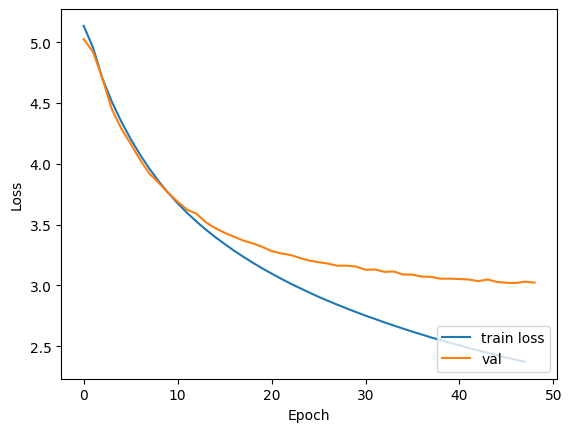

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 embedding (Embedding)       (None, 42, 300)           29966400  
                                                                 
 lstm (LSTM)                 [(None, 42, 240),         519360    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 lstm_1 (LSTM)               [(None, 42, 240),         461760    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
Total params: 30,947,520
Trainable params: 981,120
Non-trai

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    11224200    ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 240)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 240)]        0           []                               
                                                                                            

In [ ]:
decoder_model.layers[-3].input


[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

In [ ]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [ ]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [ ]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])

print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


In [ ]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

In [ ]:
seq2text(x_train_padded[0])

'film student filmed england allrounder ben stokes knocking man latenight street brawl outside pub bristol court heard fierce punchit took surprise student told court stokes charged affray incident man suffered broken eye socket '

In [ ]:
x_train_padded[0]

array([   14,   466,  5768,   303,  1377,  3636,  3608, 10079,    36,
       16485,  2086,  4733,   491,  6218,  8118,    20,  1275, 22018,
       54998,    70,  3609,   466,   225,    20,  3608,   900, 18666,
         135,    36,   809,  2127,  2372, 18667,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [ ]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  film student filmed england allrounder ben stokes knocking man latenight street brawl outside pub bristol court heard fierce punchit took surprise student told court stokes charged affray incident man suffered broken eye socket 
Original summary:  start student filmed stokes landing fierce punch man near pub end 
1/1 [==============================] - 0s 62ms/step
Predicted summary:   start ben stokes ben stokes stokes charged racist end

# 2 News:  haryana police arrested delhibased dr two associates running sex determination racket inside car tipoff police used pregnant woman trap accused working secluded forest land near delhiharyana border ultrasound machine generator fitted cars trunk also seized 
Original summary:  start dr held running sex determination racket car end 
1/1 [==============================] - 0s 66ms/step
Predicted summary:   start haryana police director arrested sex racket end

# 3 News:  body set advise irish government constitutional change voted re

In [ ]:
model.save('model.h5')
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

In [ ]:
loaded_model=tf.keras.models.load_model("model.h5")
loaded_encoder_model=tf.keras.models.load_model("encoder_model.h5")
loaded_decoder_model=tf.keras.models.load_model("decoder_model.h5")

In [ ]:
print(x_train_padded[0])
print(given_padded[0])

[   18    60  6457   905  4830  5603  5875   626    15  3612  8711   179
    30   402 17878   251   401 13168   239   164    60     9 12522  1322
  2907   848  5875   135 10874  2907  5875  1462  1528   905  4830  8711
   179     0     0     0     0     0]
[17859     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [ ]:
# Testing on training data
print(f" News: ", seq2text(given_padded[0]))
print(
    "Predicted summary: ",
    decode_sequence_seq2seq_model_with_just_lstm(
        given_padded[0].reshape(1, max_text_len), loaded_encoder_model,
        loaded_decoder_model
    )
)



 News:  cricket match hinckley amateur thirds hathern old seconds swallows green hinckley leicestershire halted macaw landed shoulders sexagenarian fielder hathern old seconds innings stop game bird big enough take someone finger batting sides captain said 
1/1 [==============================] - 0s 37ms/step
Predicted summary:   start player wears bat bat without helmet match end


In [ ]:
print("Original summary: ", seq2text(given_padded[0]))

Original summary:  cricket match hinckley amateur thirds hathern old seconds swallows green hinckley leicestershire halted macaw landed shoulders sexagenarian fielder hathern old seconds innings stop game bird big enough take someone finger batting sides captain said 
